In [1]:
import itertools
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

def minimize_power(nodes, gateways, links, debug=True):
    budgets = [i['budget'] for i in nodes]
    data = [i['data'] for i in nodes]

    min_power = float('inf')
    min_configuration = None
    # Generate all possible combinations of gateway setups
    for node_combination in itertools.permutations(range(len(nodes))):
        for gateway_combination in itertools.product([0, 1], repeat=len(gateways)):
            if debug: print("\n\n@@@@@@@@@@@@@@@@@@@@@@\ngateway combination: ", list(gateway_combination))
            total_gateway_power = 0
            
            # Calculate total power for the current gateway combination
            for i, is_gateway_on in enumerate(gateway_combination):
                if debug: print("\ti: ",i,"; Gateway on/off: ",is_gateway_on,end="; ")
                if is_gateway_on:
                    if debug: print("\t\tPower: ", gateways[i]['power'])
                    total_gateway_power += gateways[i]['power']
                if debug: print()
            if debug: print("Total Power to set up gateways: ", total_gateway_power)
            # If there are multiple gateways turned on, create priority order
            gateway_priority_orders = itertools.permutations([i for i, val in enumerate(gateway_combination) if val])
            # if debug: print("gateway_priority_orders: ", gateway_priority_orders)

            each_config_link_power = 0
            # Iterate over priority orders
            for g_priority_order in gateway_priority_orders:
                each_config_link_power = total_gateway_power
                if debug: print("\n\tcurr priority order: ", list(g_priority_order))
                node_data_remaining = copy.deepcopy(data)
                node_budget_remaining = copy.deepcopy(budgets)
                gateways_copy = copy.deepcopy(gateways)
                satisfied_nodes = [0] * len(nodes)  # Track which nodes are satisfied by each gateway
                # Assign data to gateways based on priority order
                for node_idx in node_combination:
                    remaining_data = node_data_remaining[node_idx]

                    for gateway_idx in g_priority_order:
                        if remaining_data <= 0:
                            break

                        if debug: print("\t\t\tNode: " ,node_idx,"; budget: ",nodes[node_idx], "; In gateway: ", gateway_idx, "; Remaining_data: ", remaining_data, "; Gateway: " ,gateways_copy[gateway_idx])
                        
                        if not gateways_copy[gateway_idx]: 
                            if debug: print("\t\t\t\tGateway not setup!")
                            continue
                        link_power = links[node_idx][gateway_idx]
                        if debug: print("\t\t\t\t\t\tLink Power: ", link_power)
                        if link_power<=0: 
                            if debug: print("\t\t\t\t\tNo Link!")
                            continue
                        if nodes[node_idx]['budget'] >= link_power and gateways_copy[gateway_idx]['storage']>0: 
                            # If battery left in node and gateway has storage.
                            if remaining_data>=gateways_copy[gateway_idx]['storage']: 
                                remaining_data -= gateways_copy[gateway_idx]['storage'] 
                                node_budget_remaining[node_idx]-=link_power
                                each_config_link_power+=link_power
                                gateways_copy[gateway_idx]['storage'] = 0
                                if debug: print("\t\t\t\t\t\t\tGateway storage is NULL!")
                                if debug: print("Remaining Data: ", remaining_data)
                                if remaining_data==0:
                                    satisfied_nodes[node_idx]=1
                                    if debug: print("\t\t\t\t\t\t\tNode satisfied!!")
                            else:
                                satisfied_nodes[node_idx] = 1
                                each_config_link_power+=link_power
                                gateways_copy[gateway_idx]['storage'] -= remaining_data
                                if debug: print("\t\t\t\t\t\t\tGateway storage is NOT Null: ",gateways_copy[gateway_idx]['storage'] )
                                if debug: print("\t\t\t\t\t\tNode satisfied!!")
                                break
                        if debug: print("Satisfied Nodes: ",satisfied_nodes)

                # Check if all nodes are satisfied
                if all(satisfied_nodes):
                    if debug: print("\t\tAll nodes are satisfied!")
                    if each_config_link_power < min_power:
                        min_power = each_config_link_power
                        min_configuration = (gateway_combination, satisfied_nodes)
                        if debug: print("\t\t\tGLOBAL Min Power is UPDATED!!")
                if debug: print("\t> Total Configuration Power: ", each_config_link_power)
    return min_power, min_configuration

# # Example input data
# nodes = [{'budget': 8,'data':5}, {'budget': 10,'data':8}, {'budget': 12,'data':10}]
# gateways = [{'power': 10, 'storage': 23}, {'power': 15, 'storage': 25}]  # Gateway setup power and storage
# links = [[2,3], [4,5], [6,7]]  # Transmission power from node i to gateway j

# # Run the algorithm
# min_power, min_configuration = minimize_power(nodes, gateways, links)
# if min_power==float('inf'):
#     print("All nodes are not satisfied!!")
# else:
#     print("Minimum power:", min_power)
# print("Gateway configuration:", min_configuration)


In [3]:
import random
from tqdm import tqdm

def get_gateways(num_gateways, power_range, storage_range):
    return [{'power': random.randint(*power_range), 'storage': random.randint(*storage_range)} for _ in range(num_gateways)]

In [8]:
import random
from tqdm import tqdm

def get_nodes(num_nodes, gateways, data_range, budget_range):
    num_gateways = len(gateways)
    total_storage_capacity = sum(gateway['storage'] for gateway in gateways)
    min_storage = 9999
    for gateway in gateways:
        if gateway['storage']<min_storage:
            min_storage = gateway['storage']

    total_storage_capacity = min_storage*num_gateways
    
    nodes = []
    counter = 0
    while True:
        counter+=1
        if (counter>100): 
            print("Links not satisfied for gateways: ", gateways, "; nodes: ", nodes,";")
            return None

        nodes = []
        for _ in range(num_nodes):
            data = random.randint(*data_range)
            nodes.append({'budget': random.randint(*budget_range), 'data': data}) 
        if sum(node['data'] for node in nodes) <= total_storage_capacity:
            break
    return nodes


In [9]:
import random
from tqdm import tqdm

def get_links(gateways, nodes, link_range):
    num_gateways = len(gateways)
    num_nodes = len(nodes)
    links = [[random.randint(*link_range) for _ in range(num_gateways)] for _ in range(num_nodes)]
    for _ in range(2):
        i, j = random.randint(0, num_nodes - 1), random.randint(0, num_gateways - 1)
        links[i][j] = 0
    counter = 0
    while any(row.count(0) > 1 for row in links) or any(col.count(0) > 1 for col in zip(*links)):
        counter+=1
        if (counter>100): 
            print("Links not satisfied for gateways: ", gateways, "; nodes: ", nodes, "; link_range: ", link_range,";")
            return None
        links = [[random.randint(*link_range) for _ in range(num_gateways)] for _ in range(num_nodes)]
    return links

# Num Users VS Total Power Consumed

Main Loop Progress:   0%|          | 0/9 [00:00<?, ?it/s]

Main Loop Progress:  22%|██▏       | 2/9 [00:00<00:00, 11.34it/s]

Minimum COnfiguration:  ((0, 0, 0, 0, 1, 0), [1])
Minimum COnfiguration:  ((0, 0, 0, 0, 1, 0), [1, 1])
Minimum COnfiguration:  ((1, 0, 0, 0, 0, 1), [1, 1, 1])


Main Loop Progress:  44%|████▍     | 4/9 [00:01<00:02,  1.80it/s]

Minimum COnfiguration:  ((0, 0, 1, 0, 0, 1), [1, 1, 1, 1])


Main Loop Progress:  56%|█████▌    | 5/9 [00:08<00:09,  2.46s/it]

Minimum COnfiguration:  ((0, 1, 0, 1, 1, 0), [1, 1, 1, 1, 1])


Main Loop Progress:  67%|██████▋   | 6/9 [00:51<00:42, 14.27s/it]

Minimum COnfiguration:  ((1, 0, 0, 0, 1, 1), [1, 1, 1, 1, 1, 1])


Main Loop Progress:  78%|███████▊  | 7/9 [07:06<04:03, 121.94s/it]

Minimum COnfiguration:  ((0, 0, 1, 0, 1, 1), [1, 1, 1, 1, 1, 1, 1])


Main Loop Progress:  89%|████████▉ | 8/9 [1:00:12<17:16, 1036.76s/it]

Minimum COnfiguration:  ((1, 1, 0, 0, 1, 1), [1, 1, 1, 1, 1, 1, 1, 1])


Main Loop Progress: 100%|██████████| 9/9 [6:04:59<00:00, 2433.32s/it]

Minimum COnfiguration:  ((1, 1, 1, 0, 1, 0), [1, 1, 1, 1, 1, 1, 1, 1, 1])
num_nodes:  [16, 25, 48, 49, 69, 65, 70, 92, 89]


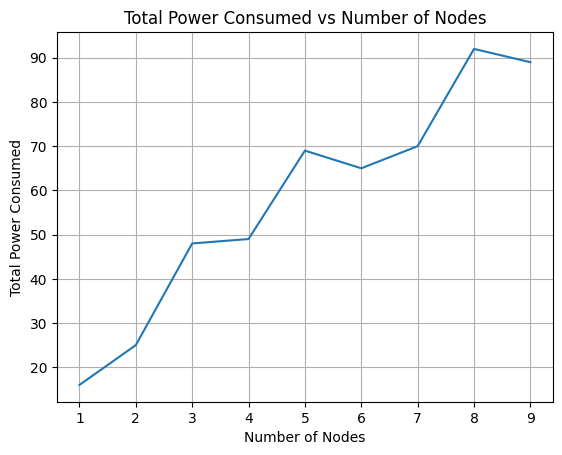

In [22]:
import itertools
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm


# Function to run the algorithm for different numbers of nodes and collect total power consumed
def run_simulation(num_nodes_range):
    total_power_consumed = []
    gateways = get_gateways(num_gateways=6, power_range=(10,20), storage_range=(15,25))
    for num_nodes in tqdm(num_nodes_range, desc="Main Loop Progress"):
        data_range = (5,10)
        link_range = (1, 20)
        budget_range = (40,50)
        nodes = get_nodes(num_nodes=num_nodes,gateways=gateways,data_range=data_range, budget_range=budget_range)
        links = get_links(gateways=gateways,link_range=link_range,nodes=nodes)
        min_power, min_configuration = minimize_power(nodes, gateways, links, debug=False)
        total_power_consumed.append(min_power)
        print("Minimum Configuration: ", min_configuration)
    return total_power_consumed

# Define the range of number of nodes
num_nodes_range = range(1, 10)  # Varying from 1 to 8 nodes

# Run the simulation
total_power_consumed = run_simulation(num_nodes_range=num_nodes_range)

print("num_nodes: ",total_power_consumed)
# Plotting
plt.plot(num_nodes_range, total_power_consumed)
plt.xlabel('Number of Nodes')
plt.ylabel('Total Power Consumed')
plt.title('Total Power Consumed vs Number of Nodes')
plt.grid(True)
plt.show()
